In [0]:
!pip install PyDrive


    100% |████████████████████████████████| 993kB 19.7MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np

import matplotlib.pyplot as plt
from keras.utils import to_categorical


Using TensorFlow backend.


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Import the corpus data

from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# !ls "/content/drive/My Drive/accent-classification-corpora"

# librispeech_path = '/content/drive/My Drive/accent-classification-corpora/librispeech'
# librispeech_preprocessed_path = '/content/drive/My Drive/accent-classification-corpora/librispeech_preprocessed'
# librit_path = '/content/drive/My Drive/accent-classification-corpora/librit'
# librit_preprocessed_path = '/content/drive/My Drive/accent-classification-corpora/librit_preprocessed'



flat_formants.pickle  librispeech_mfcc		librit_preprocessed
flat_mfcc.pickle      librispeech_preprocessed	logging
formants_rnn.h5       librit			mfcc_rnn.h5
librispeech	      librit_formants		seq_formants.pickle
librispeech_formants  librit_mfcc		seq_mfcc.pickle


In [0]:
#load spectrogram
#librispeech_spectrogram_path = "/content/drive/My Drive/accent-classification-corpora/librispeech_spectrogram_newpickle"
#librit_spectrogram_path = "/content/drive/My Drive/accent-classification-corpora/librit_spectrogram_newpickle"


# old pickles
#librispeech_spectrogram_path = "/content/drive/My Drive/librispeech_hdpickle"
#librit_spectrogram_path = "/content/drive/My Drive/librit_hdpickle"


# new 1 sec pickles
# librispeech_spectrogram_path = "/content/drive/My Drive/librispeech_1sec_hdpickle"
# librit_spectrogram_path = "/content/drive/My Drive/librit_1sec_hdpickle"


In [0]:
import glob
import pickle
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras.layers import LeakyReLU
from keras.optimizers import Adam, Nadam
import keras
import random 

In [0]:
# folders = [librispeech_spectrogram_path, librit_spectrogram_path]
# train_files = []
# val_files = []

# train_frac = 0.9

# for file_path in folders:
#   file_list = np.array(os.listdir(file_path))
#   no_of_files = len(file_list)
#   indicies = np.array(np.random.choice(no_of_files,no_of_files, replace=False))
#   no_of_train_files = int(train_frac*no_of_files)
#   train_files.append(np.array([file_path+'/'+i for i in file_list[indicies[0:no_of_train_files]]]))
#   val_files.append(np.array([file_path+'/'+ i for i in file_list[indicies[no_of_train_files:]]]))
#   print(file_path,' - train_files = ',no_of_train_files,', val files = ',no_of_files - no_of_train_files)

/content/drive/My Drive/librispeech_1sec_hdpickle  - train_files =  17527 , val files =  1948
/content/drive/My Drive/librit_1sec_hdpickle  - train_files =  5481 , val files =  610


In [0]:
# train_all_files = np.concatenate((train_files[0],train_files[1]))
# train_all_labels = np.concatenate((np.zeros(len(train_files[0])),np.ones(len(train_files[1]))))
# len_train = len(train_all_labels)
# indicies = np.array(np.random.choice(len_train,len_train, replace=False))
# train_all_files = train_all_files[indicies]
# train_all_labels = train_all_labels[indicies]

# val_all_files = np.concatenate((val_files[0],val_files[1]))
# val_all_labels = np.concatenate((np.zeros(len(val_files[0])),np.ones(len(val_files[1]))))
# len_val = len(val_all_labels)
# indicies = np.array(np.random.choice(len_val,len_val, replace=False))
# val_all_files = val_all_files[indicies]
# val_all_labels = val_all_labels[indicies]


In [0]:
# read all the pickles

def data_aggre(files, labels):
  '''
  futher cleanses
  checks if dim = 66
  
  '''
  
  
  nv_shape = (201, 66)
  features = []
  f_labels = []
  
  cnt = 0
  for i in range(files.shape[0]):
    file = files[i]
    f_label = labels[i]
    with open(file, 'rb') as jar:
      data_file = pickle.load(jar)

    #print(data_file['spectrum'].shape)  
    if(data_file['spectrum'].shape[1] == 66):
      cnt +=1
      feature = data_file['spectrum'].reshape(nv_shape)
      features.append(feature)
      f_labels.append(f_label)
  
  features_shape = (cnt, 201, 66, 1)

  features = np.array(features).reshape(features_shape) 
  f_labels = np.array(f_labels)
  return features, f_labels

# BEGIN: DO NOT RUN AGAIN!
### instead of using the generator to generate one data point at a time, I am aggregating all of them before hand

In [0]:
# import time
# start_time = time.time()

# print(val_all_files.shape)
# x, y = data_aggre(val_all_files, val_all_labels)

# print("--- %s seconds ---" % (time.time() - start_time))

# print(x.shape)
# print(y.shape)



(2558,)
--- 15.831647157669067 seconds ---
(2552, 201, 66, 1)
(2552,)


In [0]:
# this is redundent, i carries through my typo in the prev cell
# shouldve made a function and rename to val and train in the end but whatev
# x_val = x
# y_val = y

In [0]:
# pickle all the validation, extract form the specto dictionary

# DATA_PATH = "/content/drive/My Drive/cnn_proj_yvg_testing"
# with open(os.path.join(DATA_PATH, "val_1_sec_hd_feature.pickle"), 'wb') as jar:
#     pickle.dump(x_val, jar, protocol=pickle.HIGHEST_PROTOCOL)

# with open(os.path.join(DATA_PATH, "val_1_sec_hd_label.pickle"), 'wb') as jar:
#     pickle.dump(y_val, jar, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
# import time
# start_time = time.time()

# print(train_all_files.shape)
# x_train, y_train = data_aggre(train_all_files, train_all_labels)

# print("--- %s seconds ---" % (time.time() - start_time))

# print(x_train.shape)
# print(y_train.shape)


(23008,)
--- 4376.73936009407 seconds ---
(22960, 201, 66, 1)
(22960,)


In [0]:
# pickle all the validation, extract form the specto dictionary


# DATA_PATH = "/content/drive/My Drive/cnn_proj_yvg_testing"
# with open(os.path.join(DATA_PATH, "train_1_sec_hd_feature.pickle"), 'wb') as jar:
#     pickle.dump(x_train, jar, protocol=pickle.HIGHEST_PROTOCOL)

# with open(os.path.join(DATA_PATH, "train_1_sec_hd_label.pickle"), 'wb') as jar:
#     pickle.dump(y_train, jar, protocol=pickle.HIGHEST_PROTOCOL)

# END do not run again

In [0]:
# load pickles
DATA_PATH = "/content/drive/My Drive/cnn_proj_yvg_testing"
with open(os.path.join(DATA_PATH, "train_1_sec_hd_feature.pickle"), 'rb') as jar:
    x_train = pickle.load(jar)

with open(os.path.join(DATA_PATH, "train_1_sec_hd_label.pickle"), 'rb') as jar:
    y_train = pickle.load(jar)



In [0]:
with open(os.path.join(DATA_PATH, "val_1_sec_hd_feature.pickle"), 'rb') as jar:
    x_val = pickle.load(jar)

with open(os.path.join(DATA_PATH, "val_1_sec_hd_label.pickle"), 'rb') as jar:
    y_val = pickle.load(jar)

print(y_val.shape)

(2552,)


# BEGIN Only run ONCE per session!

In [0]:


# convert to one hot
# note: only execute once! per session!
y_val = np.reshape(y_val, (y_val.shape[0], -1))
y_val = to_categorical(y_val)



In [0]:

# convert to one hot for training
# note: only execute once!

y_train = np.reshape(y_train, (y_train.shape[0], -1))
y_train = to_categorical(y_train)


# END: only run once per session

In [0]:
MODEL_PATH = "/content/drive/My Drive/cnn_proj_yvg_testing/saved_models"

filepath = os.path.join(MODEL_PATH, "weights-improvement-{epoch:02d}-{loss:.4f}.h5")   
callbacks_list = [  keras.callbacks.EarlyStopping(
        monitor='val_acc', 
        patience= 10,
        mode='max',
        verbose=1),
    keras.callbacks.ModelCheckpoint(filepath,
        monitor='val_acc', 
        save_best_only=True, 
        mode='max',
        verbose=0)
]





num_classes = 2
test_label = np.array((0,1)).reshape(1,2)

activation="relu"

model = Sequential()
model.add(Conv2D(16, kernel_size=(4,4),activation='relu', input_shape=(201, 66,1),
                 kernel_initializer=keras.initializers.glorot_normal(seed=None)))
#model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(4,4), padding='SAME'))




model.add(Conv2D(32, kernel_size=(4,4),strides=(1, 1), activation='relu', padding='SAME', 
                                 kernel_initializer=keras.initializers.glorot_normal(seed=None)))
#model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
#model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(4,4),strides=(1, 1), activation='relu', padding='SAME',
                                  kernel_initializer=keras.initializers.glorot_normal(seed=None)))
model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))

# model.add(Conv2D(32, kernel_size=(4,4),strides=(1, 1), activation='relu', padding='SAME',
#                                   kernel_initializer=keras.initializers.glorot_normal(seed=None)))
# model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))


# model.add(Conv2D(32, kernel_size=(4,4),strides=(1, 1), activation='relu', padding='SAME',
#                                   kernel_initializer=keras.initializers.glorot_normal(seed=None)))
# model.add(BatchNormalization())


# model.add(MaxPooling2D(pool_size=(4,4),  padding='SAME'))

model.add(keras.layers.Dropout(0.5, noise_shape=None, seed=None))

#model.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
model.add(Flatten())
#model.add(Dense(50, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5, noise_shape=None, seed=None))

model.add(Dense(2, activation='softmax'))




model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(lr = 0.001),
              metrics=['accuracy'])



model.summary()


modelHist2 = model.fit(x_train, y_train, validation_data = (x_val, y_val),
          batch_size=32, epochs=30, callbacks = callbacks_list)


# model.fit_generator(train_generator(train_all_files[0:2],to_categorical(train_all_labels[0:2])), samples_per_epoch=1,
#                     validation_data = val_generator(val_all_files[0:2],to_categorical(val_all_labels[0:2])),
#                     nb_val_samples = 208, nb_epoch= 30,verbose = 1)

#model.fit_generator(train_generator(train_all_files,to_categorical(train_all_labels)), samples_per_epoch=20, nb_epoch= 100,verbose = 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 198, 63, 16)       272       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 50, 16, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 50, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 25, 8, 32)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 25, 8, 32)         128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 25, 8, 32)         16416     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 13, 4, 32)         0         
__________

In [0]:
from sklearn import metrics  

y_pred = model.predict(x_val)
matrix = metrics.confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)


[[1854   88]
 [ 272  338]]


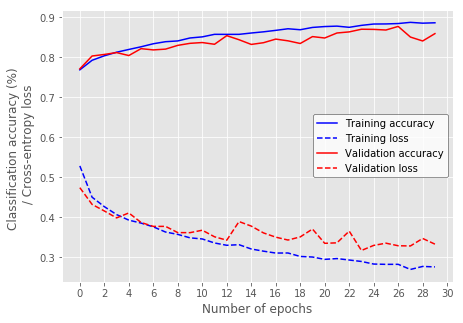

In [0]:
# Now plot
import matplotlib.pyplot as plt


epochs = np.arange(0, 31, 2.0)


plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (7,5)

plt.plot(modelHist2.history['acc'], color='blue', linestyle='solid', label='Training accuracy')
plt.plot(modelHist2.history['loss'], color='blue', linestyle='dashed', label='Training loss')

plt.plot(modelHist2.history['val_acc'], color='red', linestyle='solid', label='Validation accuracy')
plt.plot(modelHist2.history['val_loss'], color='red', linestyle='dashed', label='Validation loss')

plt.xlabel('Number of epochs')
plt.xticks(epochs)

plt.ylabel('Classification accuracy (%) \n / Cross-entropy loss')

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()

In [0]:
#data = next(train_generator(train_all_files,to_categorical(train_all_labels)))

In [0]:
DATA_PATH = "/content/drive/My Drive/cnn_proj_yvg_testing"

model.save(os.path.join(DATA_PATH, 'specto_hd_cnn_yvg_test_1sec_85_acc.h5'))

In [0]:
"""from keras.models import Model
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('dense_43').output)
data = next(train_generator(train_all_files,to_categorical(train_all_labels)))
intermediate_output = intermediate_layer_model.predict(data[0])
print(intermediate_output.shape)
data = next(train_generator(train_all_files,to_categorical(train_all_labels)))
intermediate_output = intermediate_layer_model.predict(data[0])
print(intermediate_output)
"""

In [0]:
def prediction_generator(files):
  nv_shape = (201, 66,1)
  while True:
    for file in files:
      with open(file, 'rb') as jar:
        data_file = pickle.load(jar)
        reshaped_file = data_file['spectrum']
        batch_features = np.array([reshaped_file[:,i*66:(i+1)*66].reshape(nv_shape) for i in range(24)])
      yield batch_features

 

  
pred_0 = model.predict_generator(prediction_generator(val_all_files), steps=208,verbose=1)

In [0]:
from sklearn.metrics import confusion_matrix, classification_report

def tile_val(labels):
  new_labels = []
  for label in labels:
    label_list = [label]*12
    new_labels.append(label_list)
    
  return np.array(new_labels).flatten()
    
    
new_label_list = tile_val(val_all_labels)

print(confusion_matrix(np.argmax(pred_0,axis = 1),new_label_list))
print(classification_report(np.argmax(pred_0,axis = 1),new_label_list))



In [0]:
from sklearn.decomposition import IncrementalPCA

def prediction_generator(files):
    for file in files:
      with open(file, 'rb') as jar:
        print(file)
        data_file = pickle.load(jar)
      yield data_file['spectrum']#.reshape(nv_shape)

transformer = IncrementalPCA(n_components=7, batch_size=1)
for x in prediction_generator(val_all_files):
  transformer.partial_fit(x)

In [0]:
x_transform = []
for x in prediction_generator(val_all_files):
  x_transform.append(transformer.transform(x))

In [0]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", max_iter=5,warm_start=True,verbose = 2)
for x,y in zip(x_transform,val_all_labels):
  clf.partial_fit(x.reshape(1, -1),y,classes=[0,1])



In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
class LogReg():
  def __init__(self):
    self.Talg=0
  def train(self,data_train,labels_train):
    self.Talg=LogisticRegression()
    self.Talg=self.Talg.fit(data_train,labels_train)
  def test(self,data_test,labels_predict):
    self.labels_predict=self.Talg.predict(data_test)
    self.accuracy=accuracy_score(labels_test,self.labels_predict)
    return self.accuracy, self.labels_predict
  
a=LogReg()
a.train()
accuracy,prediction=a.test()
  

In [0]:
!ls /content/drive/My\ Drive/librit_preprocessed_1sec/*.wav | wc -l

In [0]:
!ls /content/drive/My\ Drive/librispeech_preprocessed_1sec/*.wav | wc -l

In [0]:
!ls /content/drive/My\ Drive/librit_1sec_hdpickle/*.1sec_hdpickle | wc -l